In [84]:
part 'CubeSat System Modeling'{
    part 'Physical system design'{
        attribute 'dimension type' = "space";
    }
    part 'Manufacturing and testing processes'{
        attribute 'dimension type' = "time";
    }
    item 'Requirements definition and verification activities'{
        attribute 'dimension type' = "function";
    }
}

PartUsage CubeSat System Modeling (f3cfaf81-42b5-4ca9-a14b-5fc7cae573af)


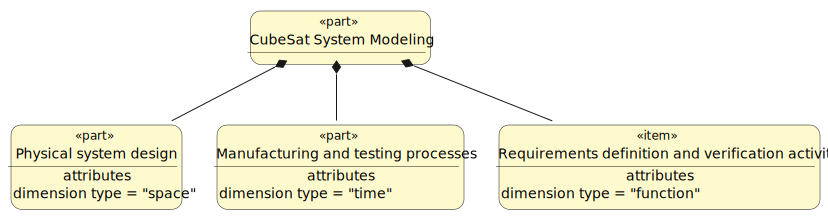

In [85]:
%viz --view=default --style=STDCOLOR "CubeSat System Modeling"

In [54]:
package cs{
    public import SI::*;
    public import ISQ::*;
    public import ScalarValues::*;
    public import ShapeItems::*;
    public import SpatialItems::*;
    public import RealFunctions::*;
    // private import MeasurementReferences::CoordinateFrame;
    public import MeasurementReferences::TranslationRotationSequence;
    public import MeasurementReferences::Translation;
    public import MeasurementReferences::Rotation;

    abstract part def BaseComponent{
        attribute sysType : SystemType;
        attribute mass : ISQ::MassValue;
        attribute massError : ISQ::MassValue;
    }

    part def Building :> BaseComponent{
        attribute location : String;
        attribute latitude : AngularMeasureValue;
        attribute longitude : AngularMeasureValue;
    }

    part def EntityComponent :> BaseComponent, SpatialItem{
        attribute tempRange : Range{
            :>> upper : ISQ::ThermodynamicTemperatureValue;
            :>> lower : ISQ::ThermodynamicTemperatureValue;
        }
        attribute material : Material[1..*];
        attribute price : Natural;
        attribute vendor : String[1..*];
        attribute geometricCenter : CartesianPosition3dVector;
        attribute gravityCenter : CartesianPosition3dVector;
    }

    part def fc :> EntityComponent{
        attribute mode;
        attribute powerConsumption {
            attribute typical : ISQ::PowerValue;
            attribute peak : ISQ::PowerValue;
        }
        port powerEnd : PowerEnd [0..*];
        port dataEnd : DataEnd [0..*];
    }

    abstract port def PortComponent :> BaseComponent;
    port def PowerEnd :> PortComponent;
    port def DataEnd :> PortComponent{
        attribute BAUDRate : Natural;
        attribute dataWidth : ISQ::StorageCapacityValue;
        attribute parityBit : Boolean;
        attribute STARTBit : ISQ::StorageCapacityValue;
        attribute STOPBit : ISQ::StorageCapacityValue;
    }

    flow def PowerLine{
		ref :>> payload : ElectricPower;
		end in source : PowerEnd;
		end out target : PowerEnd;
	}
    interface def DataLine{
        end port a : DataEnd;
        end port b : DataEnd;
    }
    interface def BUS :> DataLine;

    part def CubeSatEntity :> fc{
        part global : BaseComponent [1];
        part ss : EntityComponent [1..*];
        part pay : fc [0..*];
        part adcs : fc [1..*];
        part eps : fc [1..*];
        part obdh : fc [1..*];
        part comm : fc [1..*];
        part tcs : fc [0..*];
        part dep : fc [0..1];
        part prop : fc [0..*];
        part others : fc [0..*]; 
        part gs : Building [0..*];
    }

    enum def CurrentType{
        enum DC;
        enum AC;
    }

    item def ElectricPower{
        attribute current : ElectricCurrentValue;
        attribute voltage : SourceVoltageValue;
        attribute type : CurrentType;
    }
    
    attribute def Range{
        attribute upper;
        attribute lower;
    }
    attribute def Material{
        attribute name : String;
        attribute mechanicalProperty{
            attribute youngsModule : ISQ::ModulusOfElasticityValue;
            attribute yieldStress : ISQ::NormalStressValue;
            attribute ultimateStrength : ISQ::NormalStressValue;
        }
    }

    enum def InterfaceType{
        enum I2C;
        enum SPI;
    }
    
    enum def SystemType{
        enum GLOBAL; // 总体
        enum SS;     // 结构
        enum PAY;    // 载荷
        enum ADCS;   // 姿控
        enum EPS;    // 供电
        enum OBDH;   // 星务
        enum COMM;   // 通信
        enum TCS;    // 热控
        enum DEP;    // 部署
        enum PROP;   // 推进
        enum GS;     // 地面站
        enum OTHERS; // 其他
    }

    enum def WaveBand{
        enum UHF;
        enum VHF;
        enum X;
        enum Ka;
        enum S;
    }

    attribute PI = 3.1415927;
    attribute GravitationalConstant = 3.986e14['m³'*'s⁻²'];
    attribute EarthRadius = 6378.0[km];
    attribute SolarConstantGsun = 1412[W/m];
    attribute EarthIRConstantGearth = 217[W/m];
    attribute AlbedoRatio = 0.3;
    attribute DeepSpaceTemperatureTspace= 2.7[K];

}

Package cs (f5f5f955-7643-4e40-96d8-e54ec036cf80)


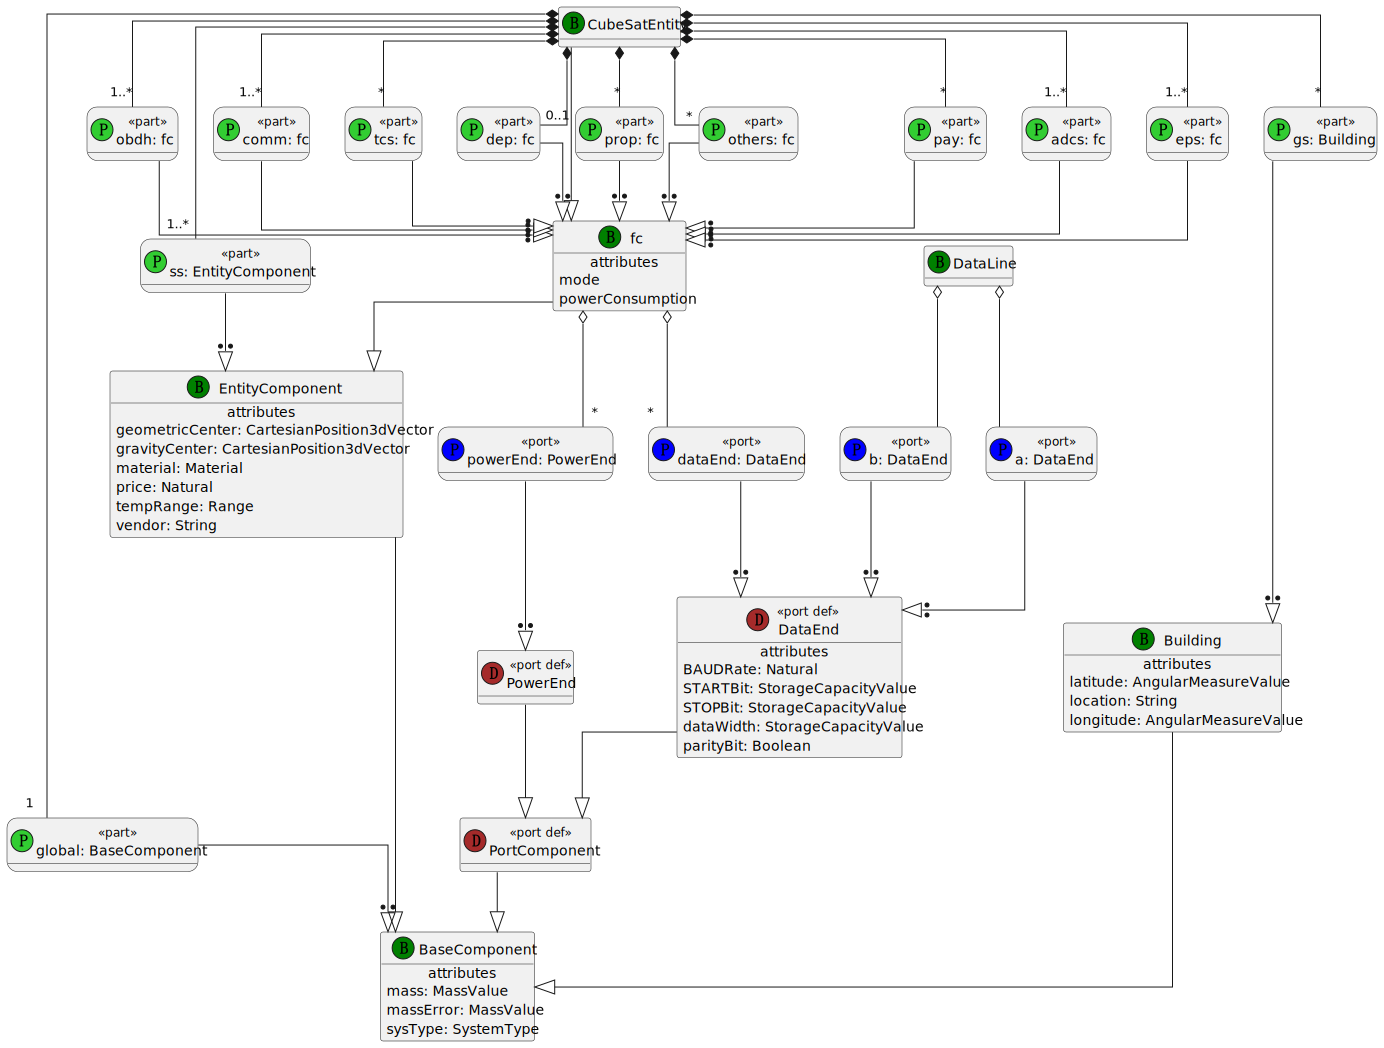

In [55]:
//In order to represent all elements in one image, abbreviations are used here.
%viz --view=default --style=PLANTUML --style=ORTHOLINE cs::CubeSatEntity cs::fc cs::EntityComponent cs::Building cs::BaseComponent cs::DataLine cs::PortComponent cs::DataEnd cs::PowerEnd

In [61]:
package CubeSat_Action{
    private import CubeSat_Base::*;
    private import CubeSat_CalcFunctions::*;
    abstract item def DesignDocument;
    item def DesignRequirements :> DesignDocument;
    item def DesignConstraint :> DesignDocument;
    item def SubsystemsConstraint :> DesignDocument;
    item def testPiece :> CubeSatEntity;
    item def Prototype :> CubeSatEntity;
    item def Design :> CubeSatEntity;
    item def usersManual :> DesignDocument;
    // item def Conditions :> DesignRequirements;

    action def CubeStar_Lifecycle{
        in item designRequirements : DesignRequirements;
        in item designConstraint : DesignConstraint;
        in item subsystemsConstraint : SubsystemsConstraint;
        out item design : Design;
        out item prototype : Prototype;
        out item results : DesignDocument;

        bind 'Global system design'.designRequirements = designRequirements;
        bind 'Global system design'.designConstraint = designConstraint;
        bind 'Global system design'.subsystemsConstraint = subsystemsConstraint;

        action 'Global system design'{
            in item designRequirements;
            in item designConstraint;
            in item subsystemsConstraint;
            out item design;
        }

        succession flow from 'Global system design'.design to 'TestPiece manufacturing'.design;
        action 'TestPiece manufacturing'{
            in item design;
            out item testPiece;
        }

        succession flow from 'Global system design'.design to 'Qualification testing'.design;
        succession flow from 'TestPiece manufacturing'.testPiece to 'Qualification testing'.testPiece;
        action 'Qualification testing'{
            in item testPiece;
            in item design;
            out item designPlus;
        }
        succession flow from 'Qualification testing'.designPlus to 'Prototype manufacturing'.design;
        action 'Prototype manufacturing'{
            in item design;
            out item prototype;
        }

        succession flow from 'Qualification testing'.designPlus to 'Acceptance testing'.design;
        succession flow from 'Prototype manufacturing'.prototype to 'Acceptance testing'.prototype;
        action 'Acceptance testing'{
            in item prototype;
            in item design;
            out item usersManual;
            out item prototypeTested;
        }
        succession flow from 'Acceptance testing'.prototypeTested to 'Protoflight'.prototype;
        succession flow from 'Acceptance testing'.usersManual to 'Protoflight'.usersManual;
        action 'Protoflight'{
            in item usersManual;
            in item prototype;
            out item results;
        }
        bind 'Protoflight'.results = results;
        bind 'Acceptance testing'.prototype = prototype;
        bind 'Qualification testing'.designPlus = design;
    }

}

Package CubeSat_Action (684001a8-38cf-4476-a798-9b37931edf40)


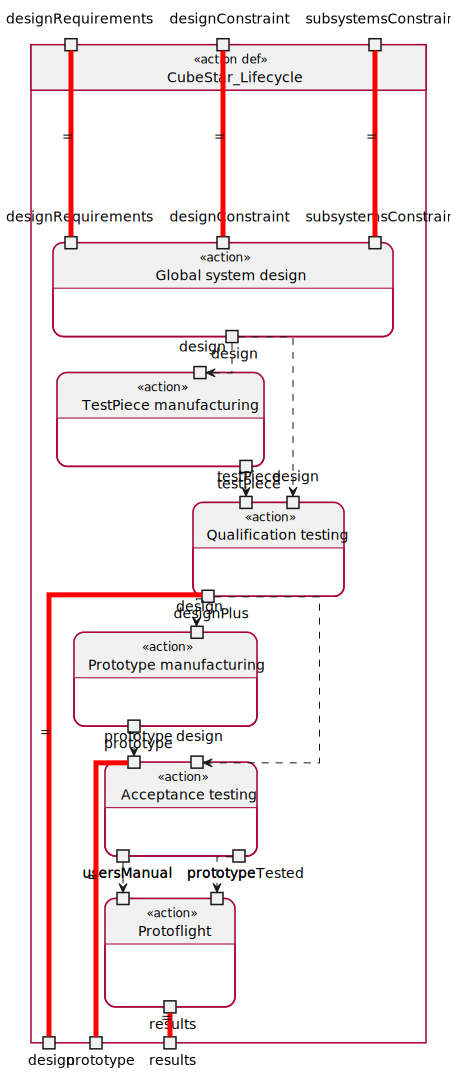

In [80]:
%viz --view=action --style=PLANTUML --style=ORTHOLINE  --style=TB   "CubeSat_Action::CubeStar_Lifecycle"

In [99]:
package CubeSatRequirementTest{
    private import CubeSat_Definitions::*;
    private import Time::Iso8601DateTime;
    requirement def CubeSatRequirement{
        attribute id : String;
        attribute description : String;
        attribute priority : RequirementPriority;
        attribute status : RequirementStatus;
        attribute verificationMethod : VerificationMethod;
        attribute verificationStatus : VerificationStatus;
    }

    part CubeSatProject{
        attribute name : String;
        attribute description : String;
        attribute startDate : Iso8601DateTime;
        attribute endDate : Iso8601DateTime;
        
    }

    requirement CubeSatRequirements : CubeSatRequirement{
        :> id = "CR-001";
        :> description = "The CubeSat must be capable of operating in low Earth orbit.";
        :> priority = RequirementPriority::Critical;
        :> status = RequirementStatus::Proposed;
        :> verificationMethod = VerificationMethod::Analysis;
        :> verificationStatus = VerificationStatus::NotStarted;
    }

    satisfy CubeSatRequirements by CubeSatProject;

    enum def RequirementPriority{
        enum Critical;
        enum High;
        enum Medium;
        enum Low;
    }

    enum def RequirementStatus {
        enum Proposed;
        enum Approved;
        enum Rejected;
        enum Implemented;
        enum Verified;
    }

    enum def VerificationMethod {
        enum Analysis;
        enum Inspection;
        enum Test;
        enum Demonstration;
    }

    enum def VerificationStatus {
        enum NotStarted;
        enum InProgress;
        enum Completed;
        enum Failed;
    }
}

Package CubeSatRequirementTest (308e2bcd-942d-493c-8917-aaf70a192f34)


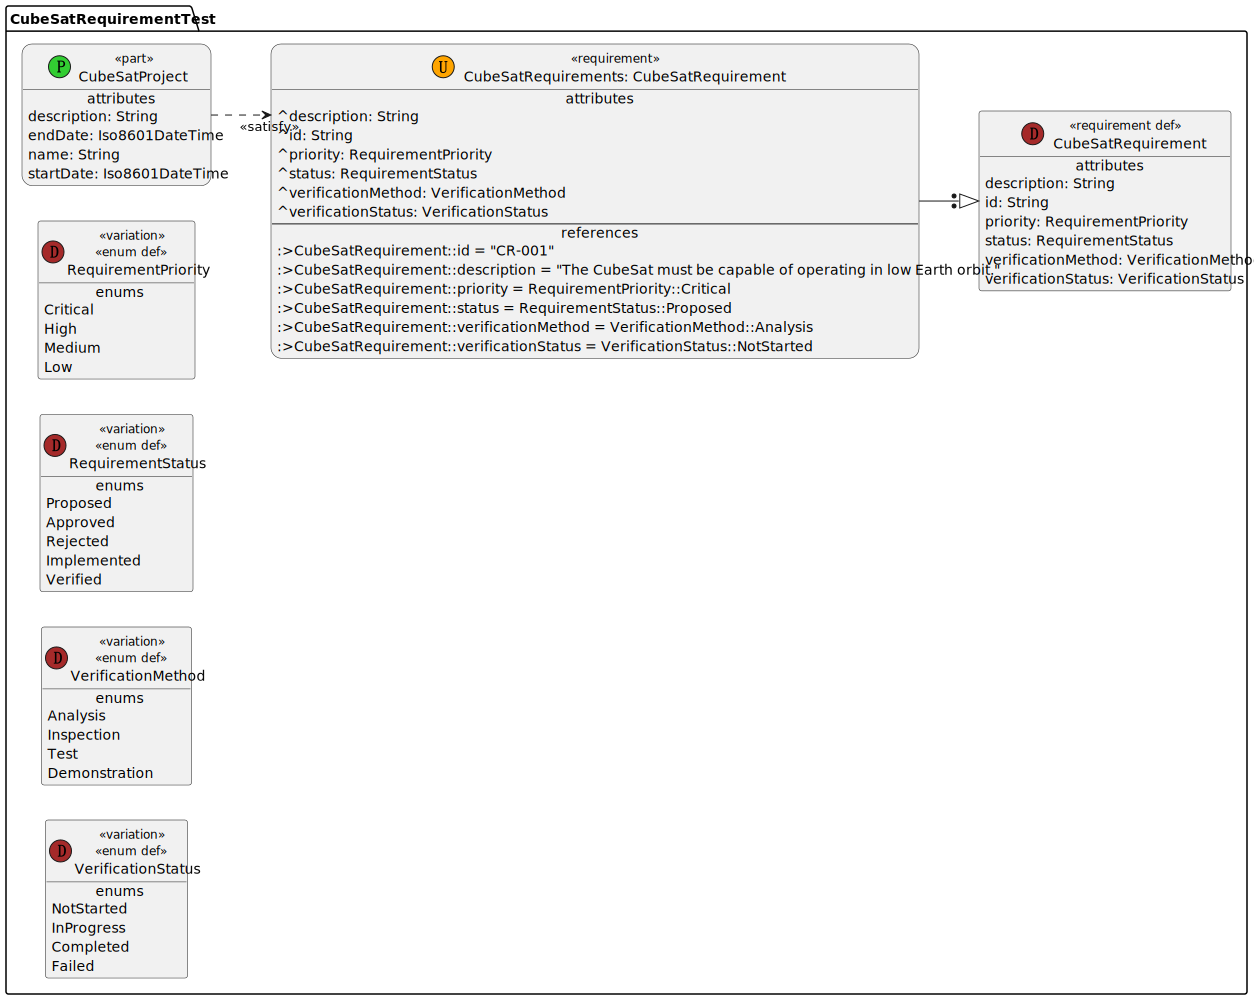

In [100]:
%viz  --view=default --style=PLANTUML --style=ORTHOLINE  --style=LR  CubeSatRequirementTest 

In [110]:
package 'CubeSatBasicModel' {
    private import ScalarValues::*;
	part def CubeSat {
		part power;
		part communication;
		part thermal;
		part control;
		part payload;
	}

	requirement def MBSEBenefits {
		doc /* 
            MBSE supports system development by enabling consistency,
            reusability, clarity, and computational analysis across 
            CubeSat subsystems. 
            */
        subject : CubeSat;
        attribute consistency : Boolean;
        attribute reusability : Boolean;
        attribute unambiguity : Boolean;
        attribute computability : Boolean;
		assert constraint {
			consistency & reusability & unambiguity & computability
		}
	}
}

Package CubeSatBasicModel (c4c520ac-0c42-46fe-8716-954519d176a4)


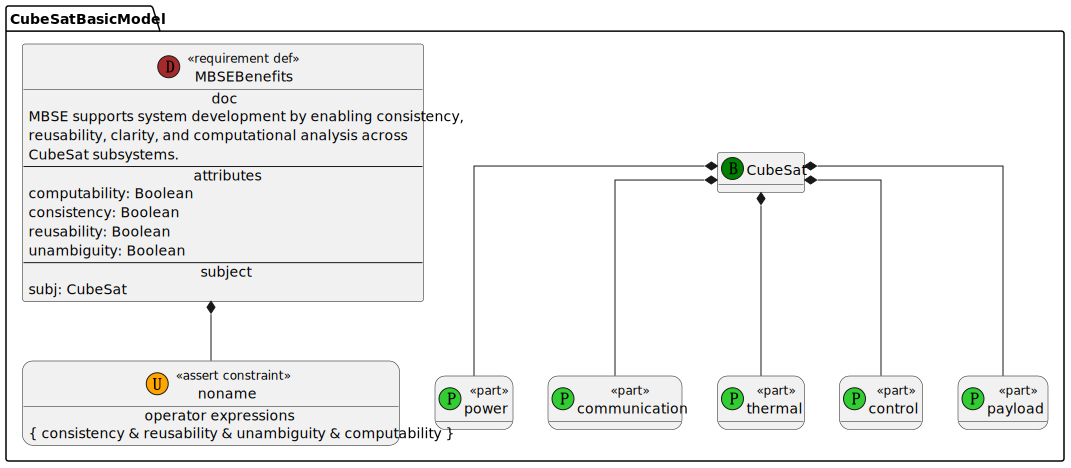

In [111]:
%viz  --view=default --style=PLANTUML --style=ORTHOLINE  --style=TB  CubeSatBasicModel 

In [158]:
package 'CubeSat Concept of MBSE' {

	doc /* Conceptual definition for the whole system */
	package SystemConceptDefinitions {
		doc /* 
            Contains conceptual-level
            parameter definitions for
            CubeSat subsystems. 
            */
		
		attribute def parameters;
		// attribute def thermalLimit;
		// attribute def communicationRange;
		// attribute def controlAlgorithm;
		// attribute def payloadSpecification;
	}

	package EngineeringDocuments {
        doc /* System engineering documentation index */
		private import MissionLifecycle::*;
        private import SatellitePhysicalDesign::*;
        
		part def SystemEngineeringText {
			ref part linksToEntity : SatelliteDesign;
            ref part linksToLifecycle : MissionLifecyclePhases;
		}
	}
    
	package SubsystemDeviceLibrary {
        doc /* Library of subsystem 
        device parameters, reused 
        in physical designs */
		private import SystemConceptDefinitions::*;

		part def Subsystem {
			attribute specification : parameters;
		}
		// part def ThermalSubsystem {
		// 	attribute limit : thermalLimit;
		// }
		// part def CommunicationSubsystem {
		// 	attribute range : communicationRange;
		// }
		// part def ControlSubsystem {
		// 	attribute algorithm : controlAlgorithm;
		// }
		// part def PayloadSubsystem {
		// 	attribute specification : payloadSpecification;
		// }
	}

	
	package SatellitePhysicalDesign {
        doc /* Physical design
        elements inheriting
        subsystem definitions */
		private import SubsystemDeviceLibrary::*;

		part def SatelliteDesign {
			part subsystem : Subsystem;
			// part thermal : ThermalSubsystem;
			// part comm : CommunicationSubsystem;
			// part control : ControlSubsystem;
			// part pay : PayloadSubsystem;
		}
	}

	
	package MissionLifecycle {
        doc /* Lifecycle indexing to 
        physical and textual elements */
		private import SatellitePhysicalDesign::*;
        
		part def MissionLifecyclePhases {
			// part conceptPhase;
			// part designPhase;
			// part testingPhase;
			// part launchPhase;
			part operationPhases;
			ref satelliteDesign : SatelliteDesign;
		}
	}

	

}

Package CubeSat Concept of MBSE (e0dc491b-ac06-42e1-8a96-efcf6d8f0a68)


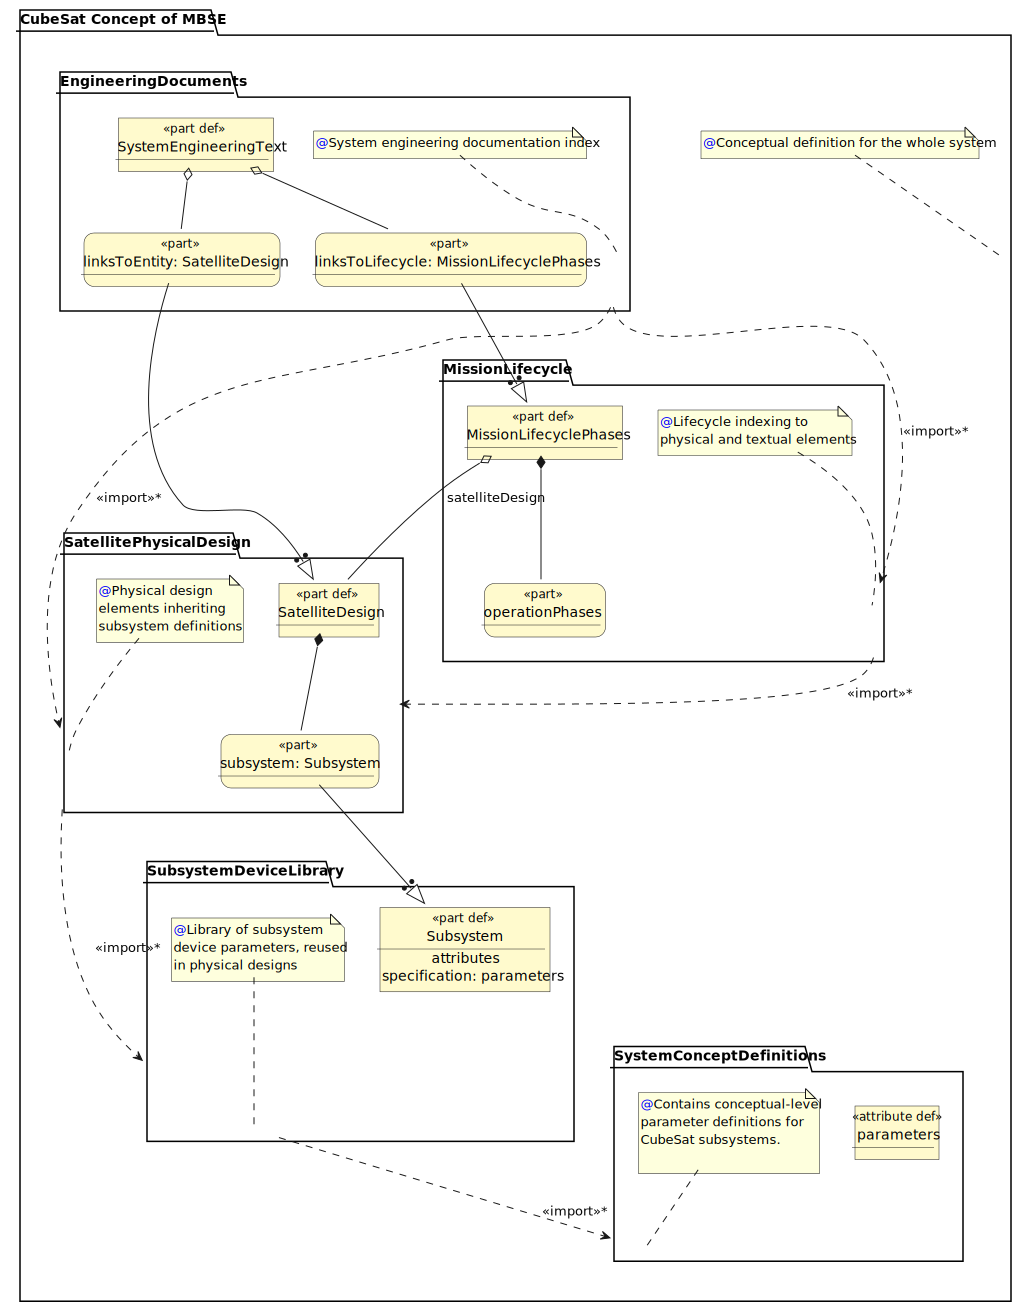

In [161]:
%viz  --view=TREE	 --style=STDCOLOR --style=SHOWIMPORTED --style=TB "CubeSat Concept of MBSE" 

In [183]:

package 'Benefits of MBSE compared to TBSE' { 

	part 'MBSE Benefits' {
        part standardization{
            doc /*Higher level of engineering standardization.*/
        	part reason1: topDownModeling{
                doc/*(1)	Each system element is supported by an explicit and standardized definition, enabling consistency and reuse.*/
            }
            part reason2: bottomUpDefinition{
                doc /*(2)	Systems modeled using domain-specific languages are less susceptible to subjective interpretation, thus reducing linguistic ambiguity.*/
            }
        }
		part automation{
            doc /*Higher level of system automation management.*/
            part reason: machineReadable{
                doc /*(3)	Digital system models are machine-readable, enabling a wide range of automated analyses and computations.*/
            }
        }
	}

	part def machineReadable{
        doc/*Develop and manage by calling APIs and other methods.*/
    }
	part def bottomUpDefinition{
        doc/*Establish parameter descriptions and functional representations for each component.*/
    }
	part def topDownModeling{
        doc/*Design system architecture based on requirements.*/
    }
}

Package Benefits of MBSE compared to TBSE (2e136dc8-0b4b-4ecf-9fa5-0b8dcc855d78)


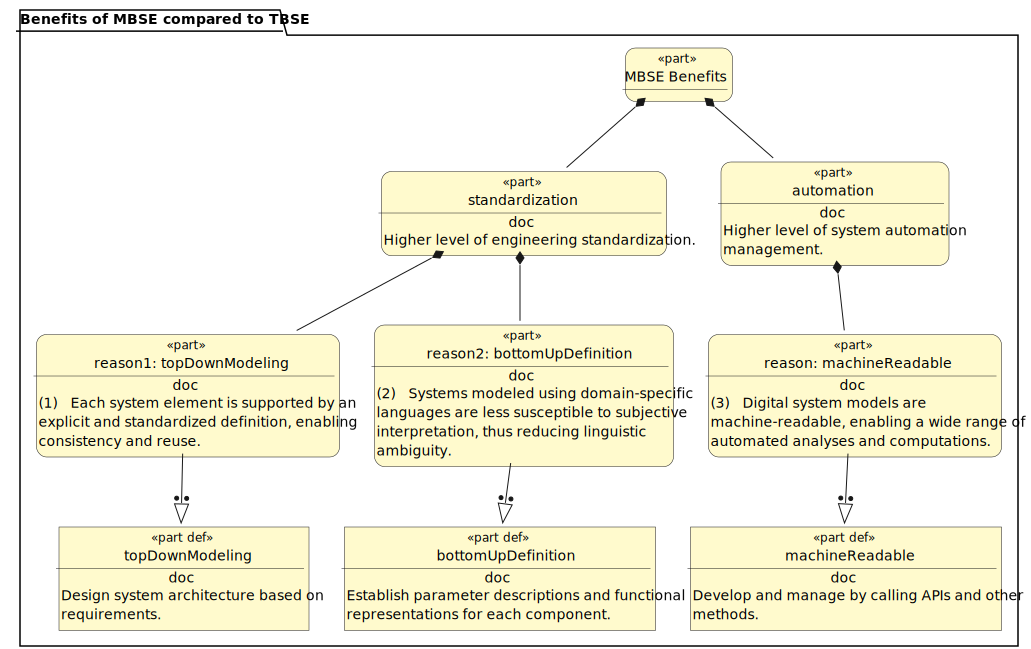

In [184]:
%viz  --view=tree	 --style=STDCOLOR --style=SHOWIMPORTED --style=TB "Benefits of MBSE compared to TBSE" 

In [203]:
package 'MBSE Challenges and SysML v2 Benefits for CubeSats' {

	part 'MBSE in CubeSat Engineering' {
		doc /* MBSE adoption in CubeSat projects is limited due to tool complexity and workflow issues. */

		part barriers {
			doc /* Why MBSE is hard to use for CubeSats. */

			part modelingNotFit {
				doc /* Most modeling tools are
                not made for CubeSat needs. */
				part problem1: slowWorkflow {
					doc /* Rigid steps like OSLP don't
                    match fast CubeSat changes. */
				}
				part problem2: hardToAdapt {
					doc /* Hard to fit models to real,
                    cross-domain engineering. */
				}
			}

			part toolLockIn {
				doc /* MBSE tools tie engineers
                to specific software. */
				part problem1: fixedFormats {
					doc /* Tools like MagicDraw or
                    Capella use locked formats. */
				}
				part problem2: limitedFlex {
					doc /* Difficult to customize
                    models in those tools. */
				}
			}
		}

		part sysMLv2Helps {
			doc /* SysML v2 solves many
            problems for CubeSat modeling. */
			part reason1: flexibleUse {
				doc /* Supports fast,
                flexible modeling. */
			}
			part reason2: openTools {
				doc /* Based on open standards,
                works with many tools. */
			}
		}
	}

	part def slowWorkflow :> methodology{
	}

	part def hardToAdapt :> methodology{
	}

	part def fixedFormats :> softwareTools{
	}

	part def limitedFlex :> softwareTools{
	}

	part def flexibleUse :> methodology{
	}

	part def openTools :> softwareTools{
	}
    
    abstract part def softwareTools;
    abstract part def methodology;
}



Package MBSE Challenges and SysML v2 Benefits for CubeSats (2f4f48fd-1b68-4ac5-aaba-0df3dafc0fe1)


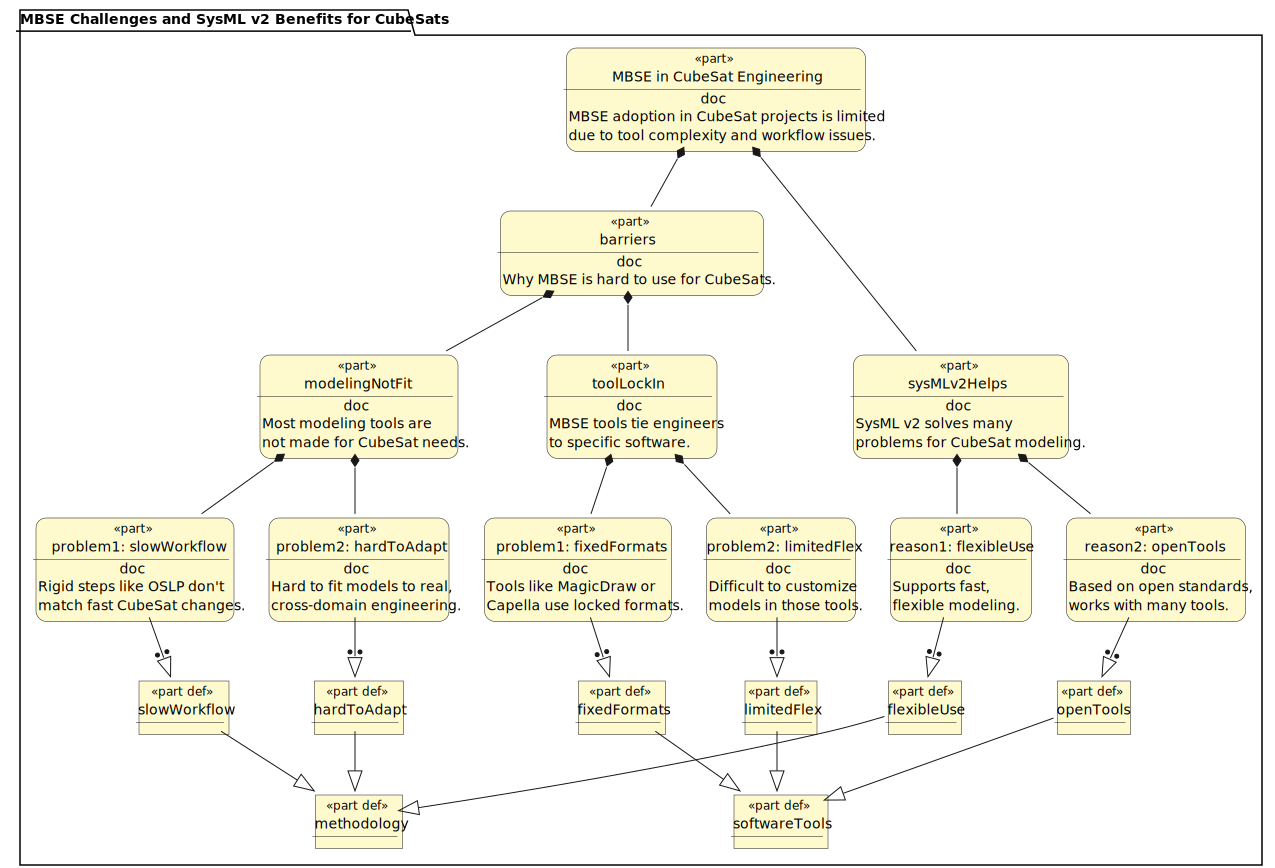

In [204]:
%viz  --view=tree	 --style=STDCOLOR --style=SHOWIMPORTED --style=TB "MBSE Challenges and SysML v2 Benefits for CubeSats" 

In [215]:
package 'SysML v2 Introduction' {

	part 'Overview of SysML v2' {
		doc /* SysML v2 is the next-generation MBSE language standardized by OMG in 2024. */

		part languageFoundation {
			doc /* SysML v2 is built on KerML for formal and precise semantics. */
			part kerMLBase  {
				doc /* KerML provides a computationally rigorous foundation, avoiding ambiguity. */
			}
			part dualSyntax  {
				doc /* Graphical + textual syntax support improves readability and tool integration. */
			}
		}

		part engineeringIntegration {
			doc /* SysML v2 promotes tool interoperability and automation. */
			part standardAPI {
				doc /* APIs enable connection to simulation, PLM, and engineering tools. */
			}
			part modularDesign  {
				doc /* Structured language features support reuse and model extension. */
			}
		}

		part toolingSupport {
			doc /* Multiple tools support SysML v2 for different use cases. */
			part sysmlPilot {
				doc /* Eclipse-based open-source implementation with Jupyter plugin. */
			}
			part sysON{
				doc /* Web-based graphical editor supporting libraries and Capella integration. */
			}
			part sysIDE  {
				doc /* Langium-based textual editor with fast indexing and cross-linking. */
			}
			part commercialMBSE {
				doc /* Tools like MagicDraw and M-Design plan SysML v2 integration. */
			}
		}

		part practicalUsage {
			doc /* SysML v2 supports modeling across design and engineering phases. */
			part rapidModeling {
				doc /* Architects can build models quickly using textual tools. */
			}
			part APIAnalysis {
				doc /* Engineers can call APIs for domain-specific analysis. */
			}
		}
	}
}


Package SysML v2 Introduction (818fe74b-ae62-4f64-a43a-77dbea5eb5a8)


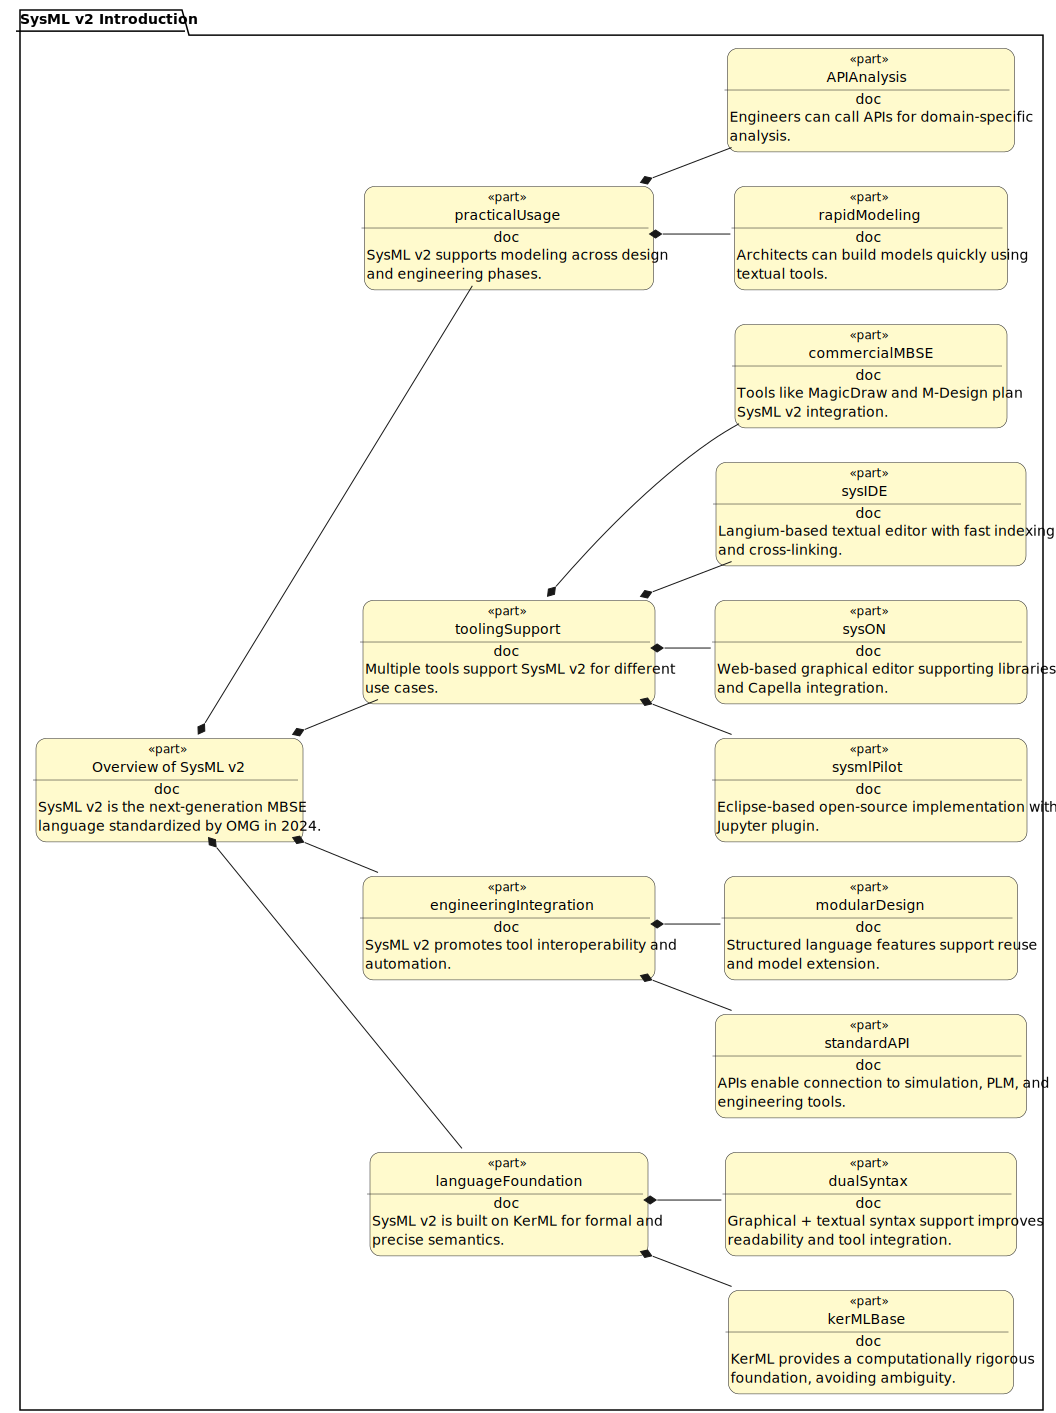

In [216]:
%viz  --view=tree	 --style=STDCOLOR --style=SHOWIMPORTED --style=LR "SysML v2 Introduction" 

In [217]:
package 'SysML v2 Overview' {

	part 'SysML v2 Summary' {
		doc /* SysML v2 is the next-generation MBSE language, standardized by OMG in 2024. */

		part foundation {
			doc /* Built on KerML for precise semantics. Supports both text and diagrams. */
		}

		part integration {
			doc /* Provides APIs for tool interoperability and supports modular modeling. */
		}

		part tools {
			doc /* Supported by multiple tools, both open-source and commercial. */
			part sysmlPilot;
			part sysON;
			part sysIDE;
			part commercialMBSE;
		}

		part usage {
			doc /* Enables fast modeling and API-driven engineering analysis. */
		}
	}
}


Package SysML v2 Overview (4aa4b789-a950-4d29-bf2b-294ef04ffcca)


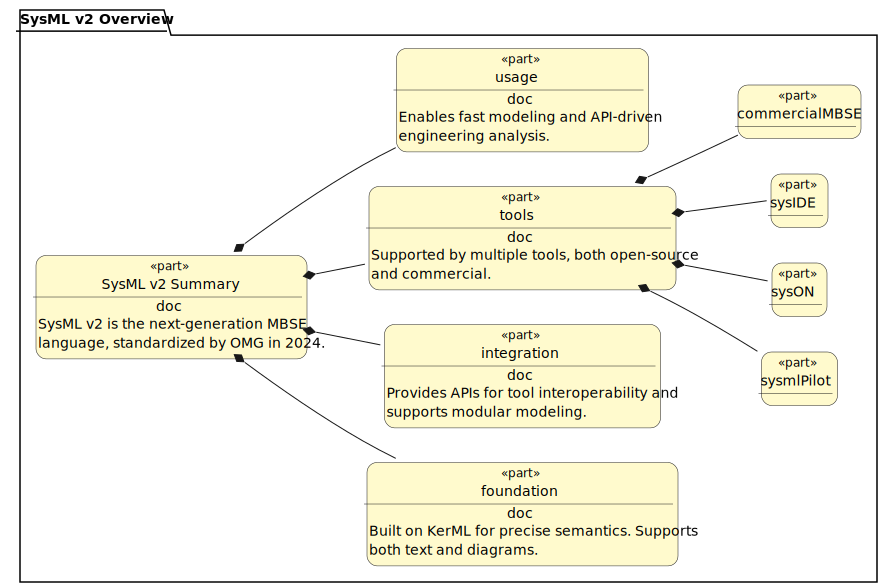

In [218]:
%viz  --view=tree	 --style=STDCOLOR --style=SHOWIMPORTED --style=LR "SysML v2 Overview" 